# Author's Notes

As of May 2021, there is no support for XGBoost on Mac (using M1 chip). You will encounter an error when training a model using XGBoost, but Logistic Regression, Random Forests, and LightGB will work successfully.

To improve the user experience, I have commented out code blocks related to XGBoost. To uncomment the code blocks, highlight the code and use the "CTRL" + "/" key combination.

If you have any issues or suggestions, please email me at ankur@unsupervisedlearningbook.com.

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 2 - End-to-End Machine Learning Project

# Google Colab Setup
**Only for users on Google Colab**

In [3]:
# # Define functions to connect to Google and change directories
# def connectDrive():
#     from google.colab import drive
#     drive.mount('/content/drive', force_remount=True)

# def changeDirectory(path):
#     import os
#     original_path = os.getcwd()
#     os.chdir(path)
#     new_path = os.getcwd()
#     print("Original path: ",original_path)
#     print("New path: ",new_path)

# # Connect to Google Drive
# connectDrive()

# # Change path
# changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

# Import Libraries

In [4]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Data Preparation

In [5]:
# Acquire Data
current_path = os.getcwd()
print(current_path)
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

/Users/jangseokhee/workspace/P/handson-unsupervised-learning


In [6]:
# Explore Data
data.shape

(284807, 31)

In [7]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [10]:
"postive label : 1 "
print("Number of fraudulent transactions:", data['Class'].sum())

Number of fraudulent transactions: 492


In [11]:
#NaN : Not a Number.   
nanCounter = np.isnan(data).sum()
# np.innan rerturn array
# Nan :True:1 | if Nan:False : 0

In [12]:
nanCounter

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [13]:
distinctCounter = data.apply(lambda x: len(x.unique()))

In [14]:
distinctCounter

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [15]:
# Generate feature matrix and labels array
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

In [16]:
dataX.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [17]:
#Feature Correlation
correlationMatrix = pd.DataFrame(data=[],index=dataX.columns,columns=dataX.columns)
for i in dataX.columns:
    for j in dataX.columns:
        correlationMatrix.loc[i,j] = np.round(pearsonr(dataX.loc[:,i],dataX.loc[:,j])[0],2)

In [18]:
correlation_file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'correlationMatrix.csv'])
correlationMatrix.to_csv(current_path+correlation_file)

Text(0, 0.5, 'Frequency Percentage')

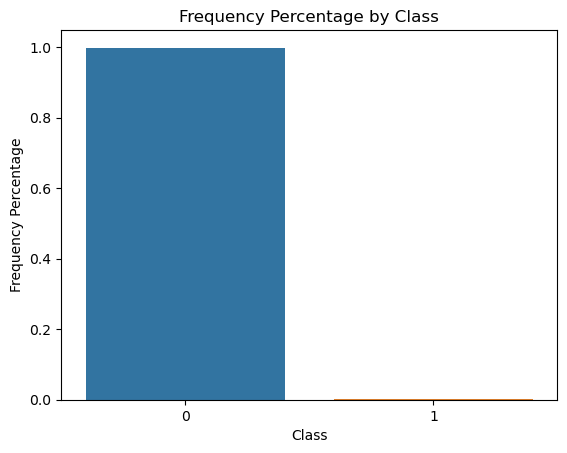

In [19]:
#Data Visualize
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=[tuple(count_classes/len(data))[0],tuple(count_classes/len(data))[1]])
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')

# Model Preparation

In [20]:
#train , test set split
X_train, X_test, y_train, y_test = train_test_split(dataX, 
                                    dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

In [21]:
len(X_train)

190820

In [22]:
len(X_test)

93987

In [23]:
y_train.sum()/len(y_train)

0.0017293784718582959

In [24]:
y_test.sum()/len(y_test)

0.0017236426314277506

In [25]:
# Feature scaling
featuresToScale = dataX.drop(['Time'],axis=1).columns

In [26]:
featuresToScale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [27]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

sX = pp.StandardScaler(copy=True)   #Standardization
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
scalingFactors = pd.DataFrame(data=[sX.mean_,sX.scale_],index=['Mean','StDev'],columns=featuresToScale)

X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

In [28]:
scalingFactors

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,0.000169,-0.001847,-0.002083,0.000909,0.002961,0.002817,-0.000048,-0.002589,-0.000516,0.000787,...,-0.000925,0.001924,-0.000187,0.001501,-0.000785,0.000352,-0.000369,0.000434,0.000083,88.324359
StDev,1.965201,1.656922,1.513847,1.414958,1.385615,1.337316,1.244564,1.216633,1.097482,1.085226,...,0.769595,0.752358,0.727151,0.626533,0.606504,0.522020,0.481376,0.402544,0.340144,246.692699


In [29]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

# Logistic Regression.     

- sklearn.linear_model.LogisticRegression.      
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html     


- L1 and L2 Regularization.    
https://medium.com/@aditya97p/l1-and-l2-regularization-237438a9caa6

In [30]:
"""
L1에 비해 L2는 이상치에 덜 민감하여 거의 모든 피처에 0이 아닌 가중치를 할당해   
안정적인 솔루션 제공
"""
penalty = 'l2'
C = 1.0                 #정규화강도(복잡성)
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C, 
            class_weight=class_weight, random_state=random_state, 
                            solver=solver, n_jobs=n_jobs)

In [31]:
"""Model Training"""
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=[0,1])

#LogisticRegression model
model = logReg

for train_index, cv_index in k_fold.split(np.zeros(len(X_train))
                                          ,y_train.ravel()):
    
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    
    loglossTraining = log_loss(y_train_fold, 
                               model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
        model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, 
                         predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train, 
                                     predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.10951981694419853
CV Log Loss:  0.10867373826591206
Training Log Loss:  0.10455700170734689
CV Log Loss:  0.10405172913614551
Training Log Loss:  0.11560561339535462
CV Log Loss:  0.1177430731959592
Training Log Loss:  0.115690450904814
CV Log Loss:  0.11818151170361621
Training Log Loss:  0.09721158870738454
CV Log Loss:  0.09715287463237625
Logistic Regression Log Loss:  0.10916058538680187


In [32]:
# Model prediction
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()

- 일반적인 분류 문제(클래스 불균형이 없는경우)에서는 오차 행렬을 사용해 결과를 평가할 수 있음     

- 오차 행렬은 true positive, true negative, falses positive, false negative

- 데이터셋이 불균형할때 오차 행렬을 상요하는 것은 의미가 없음   

In [33]:
# evaluation
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])

In [34]:
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

#### Precision-Recall curve    

- Precision = True Postive / (True postive + Fasle Positive)    
- Recall = True Positive / (True Positive + Fasle Negative)   


between precision, recall get trade-off

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.73')

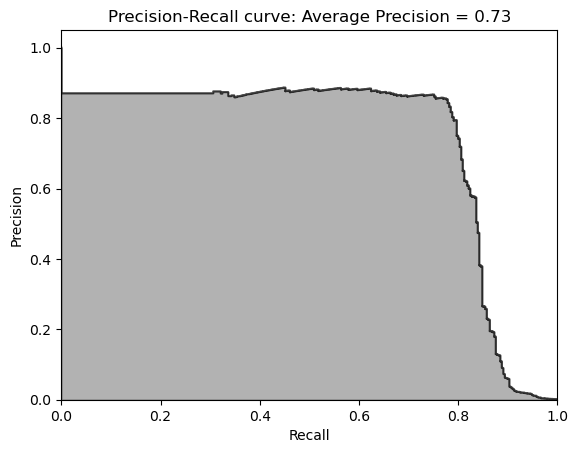

In [35]:
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

auROC curve

In [36]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

In [37]:
areaUnderROC = auc(fpr, tpr)

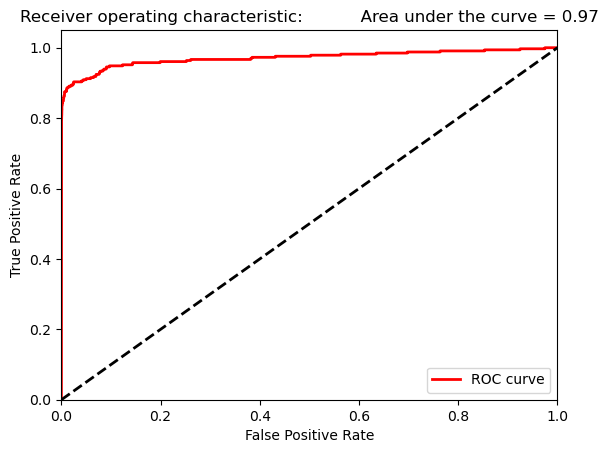

In [38]:
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

##  Model #2 :Random Forests

In [39]:
"""hyperparameter setting"""
n_estimators = 10
max_features = 'auto'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2018
class_weight = 'balanced'


RFC = RandomForestClassifier(n_estimators=n_estimators, 
        max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap, 
        oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
        class_weight=class_weight)

In [40]:
"""model training"""
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=[0,1])

model = RFC

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, \
                                model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
        model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train, 
                                          predictionsBasedOnKFolds.loc[:,1])
print('Random Forests Log Loss: ', loglossRandomForestsClassifier)

Training Log Loss:  0.0004570758747246713
CV Log Loss:  0.009090797476425144
Training Log Loss:  0.0004101805310493279
CV Log Loss:  0.012640234648018377
Training Log Loss:  0.00040027341363592047
CV Log Loss:  0.009990776910341356
Training Log Loss:  0.000387029799527202
CV Log Loss:  0.006615555561204138
Training Log Loss:  0.0004291016183715201
CV Log Loss:  0.01348243171548044
Random Forests Log Loss:  0.01036395926229389


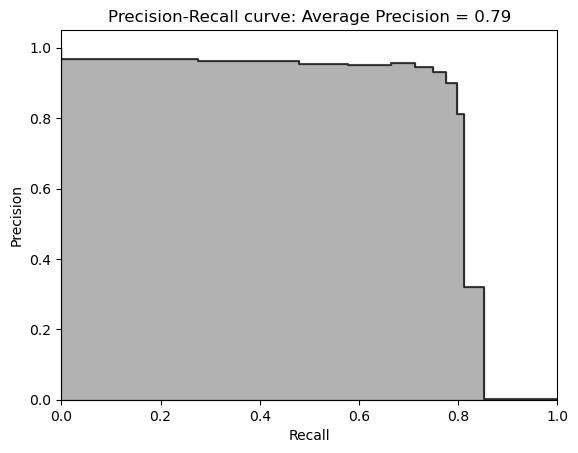

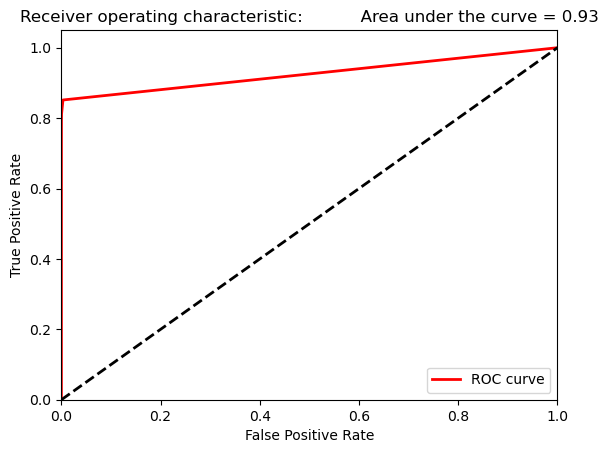

In [41]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Model #3: XGBoost

To improve the user experience, I have commented out code blocks related to XGBoost. To uncomment the code blocks, highlight the code and use the "CTRL" + "/" key combination.

In [44]:
# import xgboost as xgb
# params_xGB = {
#     'nthread':16, #number of cores
#     'learning rate': 0.3, #range 0 to 1, default 0.3
#     'gamma': 0, #range 0 to infinity, default 0 
#         # increase to reduce complexity (increase bias, reduce variance)
#     'max_depth': 6, #range 1 to infinity, default 6
#     'min_child_weight': 1, #range 0 to infinity, default 1
#     'max_delta_step': 0, #range 0 to infinity, default 0
#     'subsample': 1.0, #range 0 to 1, default 1
#         # subsample ratio of the training examples
#     'colsample_bytree': 1.0, #range 0 to 1, default 1 
#         # subsample ratio of features
#     'objective':'binary:logistic',
#     'num_class':1,
#     'eval_metric':'logloss',
#     'seed':2018,
#     'silent':1
# }


In [45]:
# trainingScores = []
# cvScores = []
# predictionsBasedOnKFolds = pd.DataFrame(data=[],
#                                     index=y_train.index,columns=['prediction'])

# for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
#                                           y_train.ravel()):
#     X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
#         X_train.iloc[cv_index,:]
#     y_train_fold, y_cv_fold = y_train.iloc[train_index], \
#         y_train.iloc[cv_index]
    
#     dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
#     dCV = xgb.DMatrix(data=X_cv_fold)
    
#     bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000, 
#                  nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
#     best_rounds = np.argmin(bst['test-logloss-mean'])
#     bst = xgb.train(params_xGB, dtrain, best_rounds)
    
#     loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
#     trainingScores.append(loglossTraining)
    
#     predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
#         bst.predict(dCV)
#     loglossCV = log_loss(y_cv_fold, \
#         predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
#     cvScores.append(loglossCV)
    
#     print('Training Log Loss: ', loglossTraining)
#     print('CV Log Loss: ', loglossCV)
    
# loglossXGBoostGradientBoosting = \
#     log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
# print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

In [46]:
# preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
# preds.columns = ['trueLabel','prediction']
# predictionsBasedOnKFoldsXGBoostGradientBoosting = preds.copy()

# precision, recall, thresholds = \
#     precision_recall_curve(preds['trueLabel'],preds['prediction'])
# average_precision = \
#     average_precision_score(preds['trueLabel'],preds['prediction'])

# plt.step(recall, precision, color='k', alpha=0.7, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])

# plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
#           average_precision))

# fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
# areaUnderROC = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic: \
#         Area under the curve = {0:0.2f}'.format(areaUnderROC))
# plt.legend(loc="lower right")
# plt.show()

## Model #4 LightGBM

In [47]:
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}

In [48]:
"""model training"""
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, \
                gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00626392
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00619346
[3]	valid_0's binary_logloss: 0.00612295
[4]	valid_0's binary_logloss: 0.00607221
[5]	valid_0's binary_logloss: 0.00601569
[6]	valid_0's binary_logloss: 0.00597401
[7]	valid_0's binary_logloss: 0.00592049
[8]	valid_0's binary_logloss: 0.00586434
[9]	valid_0's binary_logloss: 0.00580896
[10]	valid_0's binary_logloss: 0.0057568
[11]	valid_0's binary_logloss: 0.0057066
[12]	valid_0's binary_logloss: 0.00565545
[13]	valid_0's binary_logloss: 0.00560795
[14]	valid_0's binary_logloss: 0.00556133
[15]	valid_0's binary_logloss: 0.00551633
[16]	valid_0's binary_logloss: 0.00547169
[17]	valid_0's binary_logloss: 0.00542966
[18]	valid_0's binary_logloss: 0.0053893
[19]	valid_0's binary_logloss: 0.00534979
[20]	valid_0's binary_logloss: 0.0053104
[21]	valid_0's binary_logloss: 0.00527345
[22]	valid_0's binary_logloss: 0.00523756
[23]	valid_0's binary_loglo

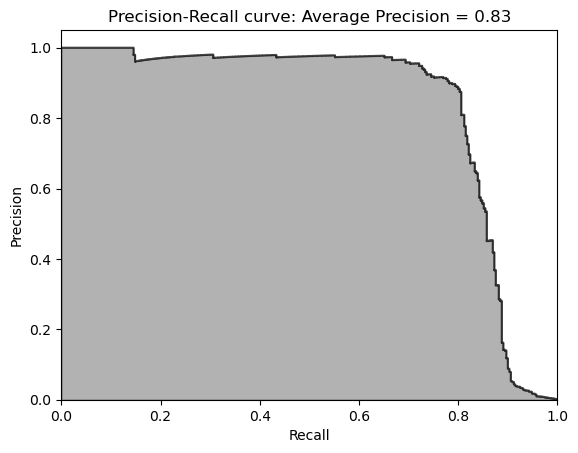

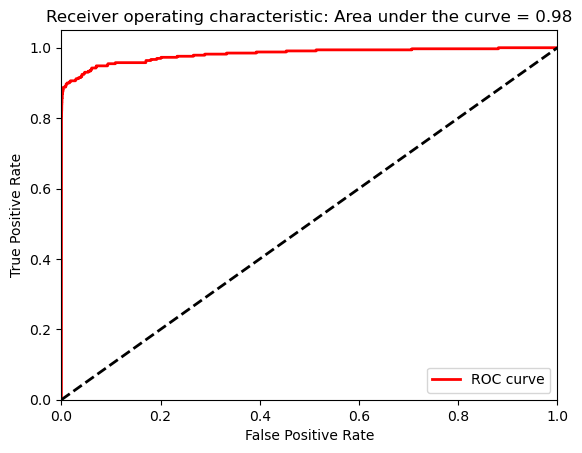

In [49]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Test Set Evaluation

In [50]:
predictionsTestSetLogisticRegression = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = \
    logReg.predict_proba(X_test)[:,1]
logLossTestSetLogisticRegression = \
    log_loss(y_test, predictionsTestSetLogisticRegression)

In [51]:
predictionsTestSetRandomForests = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = \
    RFC.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = \
    log_loss(y_test, predictionsTestSetRandomForests)

In [52]:
# predictionsTestSetXGBoostGradientBoosting = \
#     pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
# dtest = xgb.DMatrix(data=X_test)
# predictionsTestSetXGBoostGradientBoosting.loc[:,'prediction'] = \
#     bst.predict(dtest)
# logLossTestSetXGBoostGradientBoosting = \
#     log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)

In [53]:
predictionsTestSetLightGBMGradientBoosting = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLightGBMGradientBoosting.loc[:,'prediction'] = \
    gbm.predict(X_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = \
    log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)

In [54]:
print("Log Loss of Logistic Regression on Test Set: ", \
          logLossTestSetLogisticRegression)
print("Log Loss of Random Forests on Test Set: ", \
          logLossTestSetRandomForests)
# print("Log Loss of XGBoost Gradient Boosting on Test Set: ", \
#           logLossTestSetXGBoostGradientBoosting)
print("Log Loss of LightGBM Gradient Boosting on Test Set: ", \
          logLossTestSetLightGBMGradientBoosting)

Log Loss of Logistic Regression on Test Set:  0.09691617716783994
Log Loss of Random Forests on Test Set:  0.009018284462863804
Log Loss of LightGBM Gradient Boosting on Test Set:  0.0025167825399268085


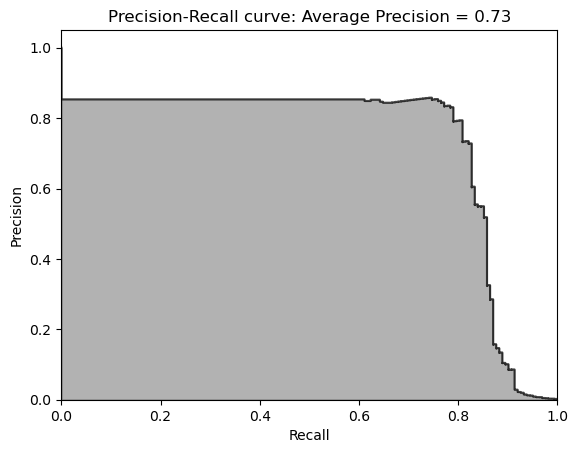

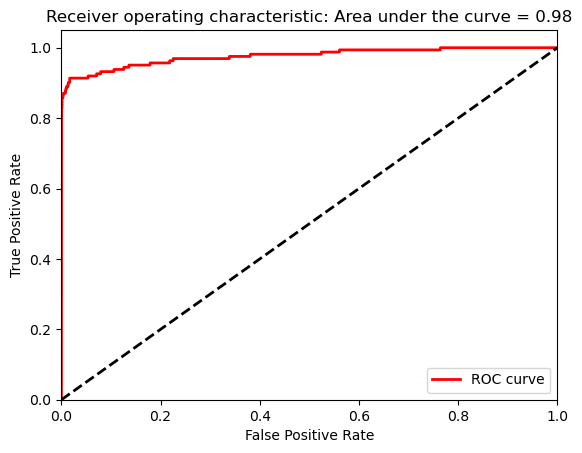

In [55]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetLogisticRegression)
average_precision = \
    average_precision_score(y_test,predictionsTestSetLogisticRegression)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLogisticRegression)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

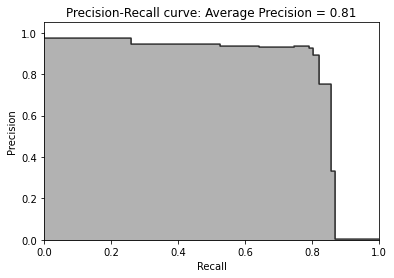

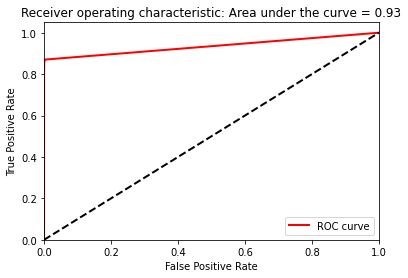

In [ ]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetRandomForests)
average_precision = \
    average_precision_score(y_test,predictionsTestSetRandomForests)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetRandomForests)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [56]:
# precision, recall, thresholds = \
#     precision_recall_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
# average_precision = \
#     average_precision_score(y_test,predictionsTestSetXGBoostGradientBoosting)

# plt.step(recall, precision, color='k', alpha=0.7, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])

# plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
#           average_precision))

# fpr, tpr, thresholds = \
#     roc_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
# areaUnderROC = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic: \
# Area under the curve = {0:0.2f}'.format(areaUnderROC))
# plt.legend(loc="lower right")
# plt.show()

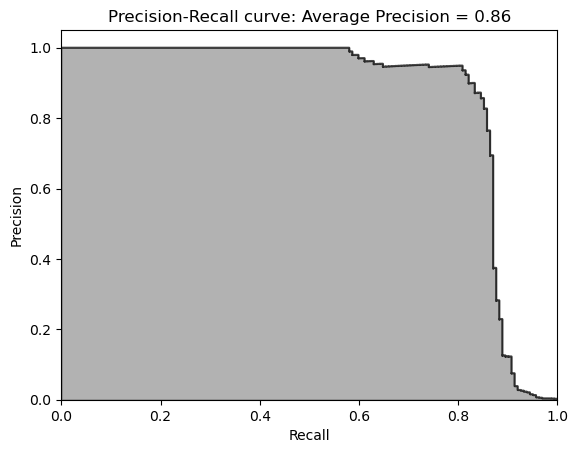

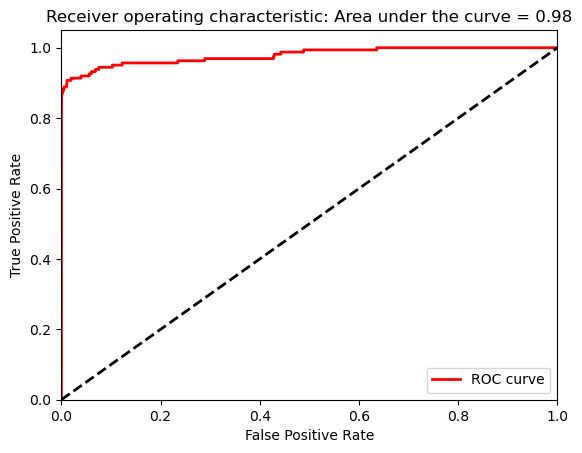

In [57]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
average_precision = \
    average_precision_score(y_test,predictionsTestSetLightGBMGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = \
    roc_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Ensemble

In [58]:
# Without XGBoost
predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[],index=y_train.index)
predictionsBasedOnKFoldsFourModels = predictionsBasedOnKFoldsFourModels.join(
    predictionsBasedOnKFoldsLogisticRegression['prediction'].astype(float), \
    how='left').join(predictionsBasedOnKFoldsRandomForests['prediction'] \
    .astype(float),how='left',rsuffix="2").join( \
    predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float), \
    how='left',rsuffix="4")
predictionsBasedOnKFoldsFourModels.columns = \
    ['predsLR','predsRF','predsLightGBM']

# predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[],index=y_train.index)
# predictionsBasedOnKFoldsFourModels = predictionsBasedOnKFoldsFourModels.join(
#     predictionsBasedOnKFoldsLogisticRegression['prediction'].astype(float), \
#     how='left').join(predictionsBasedOnKFoldsRandomForests['prediction'] \
#     .astype(float),how='left',rsuffix="2").join( \
#     predictionsBasedOnKFoldsXGBoostGradientBoosting['prediction'].astype(float), \
#     how='left',rsuffix="3").join( \
#     predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float), \
#     how='left',rsuffix="4")
# predictionsBasedOnKFoldsFourModels.columns = \
#     ['predsLR','predsRF','predsXGB','predsLightGBM']

In [59]:
X_trainWithPredictions = \
    X_train.merge(predictionsBasedOnKFoldsFourModels,
                  left_index=True,right_index=True)

In [ ]:
"""hyperparmaeter"""
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}

In [60]:
"""model training"""
trainingScores = []
cvScores = []
predictionsBasedOnKFoldsEnsemble = \
    pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = \
        X_trainWithPredictions.iloc[train_index,:], \
        X_trainWithPredictions.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, \
        gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossEnsemble = log_loss(y_train, \
        predictionsBasedOnKFoldsEnsemble.loc[:,'prediction'])
print('Ensemble Log Loss: ', loglossEnsemble)

[1]	valid_0's binary_logloss: 0.00557106
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00552259
[3]	valid_0's binary_logloss: 0.00547473
[4]	valid_0's binary_logloss: 0.00542905
[5]	valid_0's binary_logloss: 0.0053866
[6]	valid_0's binary_logloss: 0.00534577
[7]	valid_0's binary_logloss: 0.00530477
[8]	valid_0's binary_logloss: 0.00526243
[9]	valid_0's binary_logloss: 0.00520904
[10]	valid_0's binary_logloss: 0.00516823
[11]	valid_0's binary_logloss: 0.00513017
[12]	valid_0's binary_logloss: 0.00509225
[13]	valid_0's binary_logloss: 0.00505446
[14]	valid_0's binary_logloss: 0.00501374
[15]	valid_0's binary_logloss: 0.00497124
[16]	valid_0's binary_logloss: 0.00493152
[17]	valid_0's binary_logloss: 0.0048985
[18]	valid_0's binary_logloss: 0.00486416
[19]	valid_0's binary_logloss: 0.00482918
[20]	valid_0's binary_logloss: 0.00479462
[21]	valid_0's binary_logloss: 0.0047619
[22]	valid_0's binary_logloss: 0.00472917
[23]	valid_0's binary_logl

In [61]:
print('Feature importances:', list(gbm.feature_importance()))

Feature importances: [139, 113, 51, 82, 234, 74, 59, 257, 155, 55, 156, 69, 129, 126, 348, 80, 182, 81, 56, 448, 55, 131, 164, 138, 124, 177, 232, 71, 138, 315, 216, 340, 404]


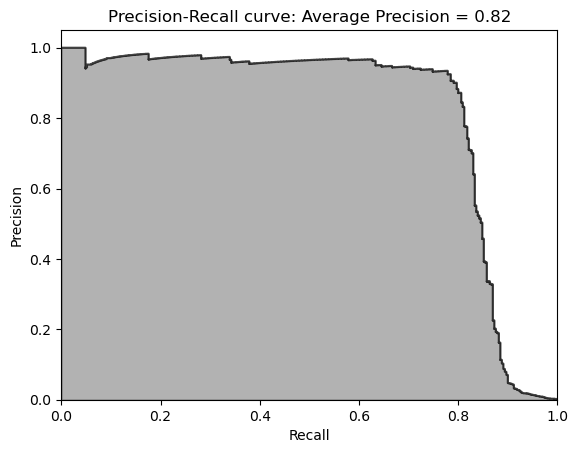

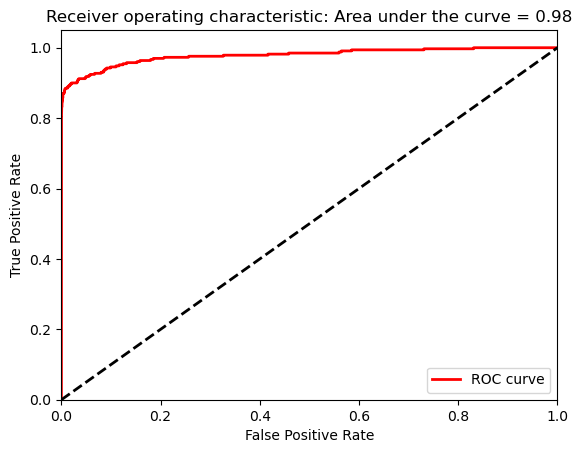

In [63]:
preds = pd.concat([y_train,predictionsBasedOnKFoldsEnsemble.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

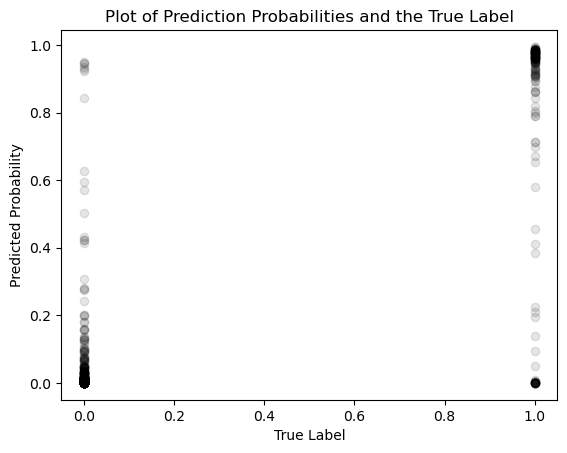

In [64]:
scatterData = predictionsTestSetLightGBMGradientBoosting.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', 
                 fit_reg=False, scatter_kws={'alpha':0.1},
                 data=scatterData).set_title( \
                'Plot of Prediction Probabilities and the True Label')

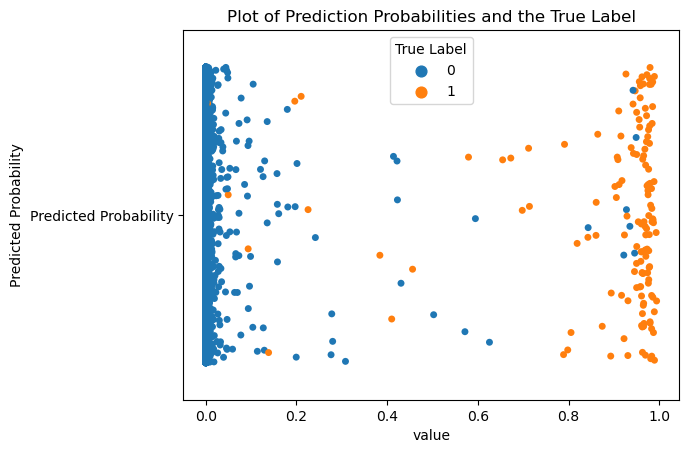

In [65]:
scatterDataMelted = pd.melt(scatterData, "True Label", \
                            var_name="Predicted Probability")
ax = sns.stripplot(x="value", y="Predicted Probability", \
                   hue='True Label', jitter=0.4, \
                   data=scatterDataMelted).set_title( \
                   'Plot of Prediction Probabilities and the True Label')

In [ ]:
# Pipeline for New Data
# first, import new data into a dataframe called 'newData'
# second, scale data
# newData.loc[:,featuresToScale] = sX.transform(newData[featuresToScale])
# third, predict using LightGBM
# gbm.predict(newData, num_iteration=gbm.best_iteration)

# Conclusion